# Emerging Topics -- AI

This code was created from Martha and Sean's emerging topic code and was used to create the hottest/coldest topics static graphics for the full, pandemics, and coronavirus corpora.

In [153]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [154]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns
import ast

### Data Ingestion

In [155]:
df = pd.read_csv("/home/zz3hs/git/dspg21RnD/data_shiny/abstracts_shiny.csv")# pandemic corpus
df.reset_index(inplace=True)
df = df[df["IS_AI_BERT"] == True]

In [156]:
df

,index,PROJECT_ID,FY,PROJECT_START_DATE,PROJECT_TITLE,final_frqwds_removed,IS_AI_OECD,IS_AI_BERT,DEPARTMENT,AGENCY
0,0,812232,2015,1/13/2015,MCINTIRE-STENNIS ADMINISTRATION PROJECT,"['direct', 'identification', 'basic', 'apply',...",NaN,True,USDA,NIFA
2,2,1101885,2018,5/10/2018,REAL-TIME FORMATIVE ASSESSMENT OF NGSS MATHEMA...,"['previous', 'grant', 'award', 'ies', 'nationa...",NaN,True,ED,IES
3,3,1101875,2018,5/10/2018,GRASPABLE MATH ACTIVITIES,"['previous', 'grant', 'award', 'ies', 'graspab...",NaN,True,ED,IES
4,4,1101877,2018,5/10/2018,STRUCTURED ADAPTIVITY FOR COMPUTER SCIENCE CODING,"['team', 'prototype', 'web', 'coding', 'progre...",NaN,True,ED,IES
5,5,1101876,2018,5/10/2018,DEVELOPMENTALLY APPROPRIATE TECHNOLOGY FOR SCI...,"['prototype', 'science', 'quest', 'science', '...",NaN,True,ED,IES
...,...,...,...,...,...,...,...,...,...,...
14190,14190,1086737,2018,10/1/2018,CAREER: NEW LEARNING-BASED ALGORITHMS FOR THE ...,"['artificial_intelligence', 'fuel', 'recent', ...",True,True,NSF,NSF
14191,14191,1089879,2018,10/1/2018,SATC: CORE: FRONTIER: COLLABORATIVE: END-TO-EN...,"['frontier', 'trustworthy', 'machine_learning'...",NaN,True,NSF,NSF
14194,14194,676893,2014,9/5/2014,"MODEL PREDICTIVE CONTROL OF AN UNDERDAMPED, PN...","['predictive', 'underdamped', 'pneumatically_a...",NaN,True,NASA,NASA
14195,14195,1073868,2018,9/5/2018,ELUCIDATING THE NEURAL SUBSTRATE FOR VALUE-BAS...,"['order', 'optimal', 'value', 'decision', 'ani...",NaN,True,HHS,NIH


In [157]:
docs = df["final_frqwds_removed"]

clean_docs = []
for doc in docs:
    doc = ast.literal_eval(doc)
    clean_docs.append(doc)

In [158]:
text = []

for abstract in clean_docs:
    text.append(" ".join(abstract))

In [159]:
text[0]

'direct identification basic apply scientific implementation ensure optimum management forest administration scientist discipline'

### Functions needed for all models

In [160]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [161]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- Optimal Model: full dataset, 75 topics, random_state = 14
- Pandemic Model: pandemic dataset, 30, random_state = 1
- Coronavirus Model: coronavirus dataset, 30, random_state = 1

In [162]:
# use for full dataset
#tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
#tf_idf = tfidf_vectorizer.fit_transform(text)

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False)
tf_idf = tfidf_vectorizer.fit_transform(text)


In [163]:
# create model

num_topics = 20

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 3.6106855869293213


### Emerging Topics

In [164]:
df['PROJECT_START_DATE']

0        1/13/2015
2        5/10/2018
3        5/10/2018
4        5/10/2018
5        5/10/2018
           ...    
14190    10/1/2018
14191    10/1/2018
14194     9/5/2014
14195     9/5/2018
14201    9/10/2013
Name: PROJECT_START_DATE, Length: 7658, dtype: object

In [165]:
from datetime import datetime
project_start_date = df["PROJECT_START_DATE"]
project_start_date = pd.to_datetime(project_start_date)
df["START_YEAR"] = project_start_date.dt.year
df = df[df.START_YEAR.notnull()]


In [166]:
start_year = df["START_YEAR"].tolist()
a = [x for x in start_year if type(x) == None]
print(a)

[]


In [167]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]


In [168]:
topic_frame

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,START_YEAR
0,0.001068,0.001259,0.000000,0.000000,0.000000,0.037093,0.000000,0.000000,0.005499,0.008913,...,0.0,0.008327,0.000000,0.000000,0.000000,0.000000,0.003993,0.000141,0.000000,2015.0
1,0.000000,0.000000,0.000000,0.147930,0.000000,0.021022,0.003680,0.000000,0.000000,0.000000,...,0.0,0.010401,0.003184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
2,0.000000,0.000000,0.000000,0.158793,0.000000,0.000000,0.000000,0.000000,0.005506,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.003091,0.000000,0.001043,0.000805,2018.0
3,0.000329,0.002064,0.001617,0.101134,0.000000,0.000873,0.000000,0.004909,0.011306,0.000000,...,0.0,0.001716,0.000000,0.000000,0.000000,0.000000,0.001581,0.000000,0.001386,2018.0
4,0.000000,0.000000,0.000000,0.165346,0.000000,0.018778,0.000000,0.001820,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001041,0.008122,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7653,0.009843,0.070209,0.000494,0.006502,0.000000,0.000000,0.000000,0.000000,0.025019,0.013536,...,0.0,0.036043,0.052176,0.045694,0.001998,0.000000,0.000000,0.000000,0.000000,2010.0
7654,0.016007,0.000000,0.004492,0.018160,0.001452,0.018309,0.000971,0.000000,0.010277,0.012109,...,0.0,0.002019,0.007713,0.000467,0.000000,0.000169,0.001811,0.000000,0.002751,NaN
7655,0.000000,0.000000,0.137851,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000456,0.008681,0.000000,0.000000,0.000000,0.000000,0.000000,2006.0
7656,0.000000,0.072872,0.000000,0.000000,0.000000,0.000000,0.158523,0.000000,0.000000,0.001865,...,0.0,0.000000,0.011579,0.001477,0.000000,0.000000,0.000000,0.000000,0.000000,NaN


In [169]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2020]

In [170]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [171]:
topic_frame.head()

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
0,1979,0.013305,0.000000,0.004183,0.013756,0.000000,0.032905,0.000000,0.000000,0.008042,...,0.124067,0.000000,0.013699,0.000000,0.000000,0.004024,0.015368,0.000000,0.000000,0.000000
1,1984,0.001381,0.010450,0.000361,0.005022,0.001826,0.033323,0.000000,0.010642,0.004211,...,0.000000,0.003321,0.083461,0.006375,0.013136,0.000000,0.024502,0.000000,0.000000,0.000000
2,1986,0.002612,0.000000,0.042313,0.006869,0.000000,0.031147,0.018032,0.001281,0.010119,...,0.008286,0.002702,0.017086,0.000943,0.002157,0.000128,0.013077,0.003252,0.004763,0.025063
3,1988,0.000000,0.000000,0.000000,0.000000,0.077833,0.006678,0.000000,0.006194,0.017339,...,0.000000,0.000000,0.027479,0.000000,0.064453,0.001518,0.000000,0.000000,0.000938,0.000000
4,1989,0.013279,0.008113,0.000852,0.025136,0.003821,0.016992,0.018403,0.002902,0.014727,...,0.002038,0.000000,0.009368,0.028654,0.003160,0.000546,0.001012,0.002713,0.013645,0.000903


In [172]:
# filter topic_frame for years 2010 - 2019

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2020] 

In [173]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
24,2010,0.007071,0.013190,0.012560,0.014264,0.011800,0.011710,0.007443,0.012090,0.010983,...,0.010101,0.008041,0.012793,0.013618,0.004755,0.007724,0.012196,0.004457,0.013136,0.004547
25,2011,0.006013,0.014915,0.012473,0.018228,0.010266,0.014660,0.007397,0.010605,0.009037,...,0.011601,0.003635,0.011743,0.014078,0.005726,0.010182,0.012122,0.002551,0.010876,0.007655
26,2012,0.006633,0.009091,0.008745,0.013272,0.010196,0.016404,0.010799,0.010460,0.010085,...,0.009011,0.004865,0.012381,0.011843,0.006389,0.008640,0.012642,0.004919,0.010533,0.005785
27,2013,0.007802,0.010496,0.008425,0.013387,0.007434,0.014293,0.006860,0.009268,0.012393,...,0.007753,0.004835,0.015656,0.016149,0.007746,0.009380,0.011962,0.005616,0.012843,0.005584
28,2014,0.007168,0.008786,0.010778,0.014895,0.009146,0.018069,0.007122,0.007268,0.009280,...,0.011799,0.006317,0.014310,0.015208,0.007568,0.007317,0.012723,0.005948,0.007904,0.007051
29,2015,0.006005,0.013162,0.009295,0.015617,0.007581,0.012894,0.006731,0.009063,0.012987,...,0.006849,0.007259,0.012576,0.013153,0.010310,0.010407,0.011629,0.005979,0.011293,0.007007
30,2016,0.006998,0.014131,0.014029,0.012608,0.009350,0.013708,0.009909,0.011468,0.011195,...,0.009430,0.005519,0.011524,0.012106,0.006582,0.007882,0.011181,0.003740,0.010411,0.005164
31,2017,0.006731,0.013673,0.012603,0.012740,0.009849,0.013380,0.010773,0.011937,0.009701,...,0.008575,0.006154,0.013024,0.012926,0.007066,0.009258,0.010429,0.004723,0.010110,0.006517
32,2018,0.005953,0.009733,0.008924,0.018483,0.010784,0.014662,0.008151,0.011256,0.010307,...,0.007711,0.006218,0.011457,0.012481,0.005328,0.007929,0.012070,0.004254,0.011560,0.004841
33,2019,0.004411,0.010320,0.005855,0.016029,0.007267,0.016002,0.006216,0.010729,0.011321,...,0.005663,0.007066,0.011627,0.008898,0.005989,0.003601,0.015879,0.011447,0.010301,0.006057


In [174]:
topic_wts_se_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
24,2010,0.000707,0.001584,0.002092,0.001803,0.001876,0.001166,0.001049,0.001608,0.001531,...,0.001730,0.001716,0.001307,0.001510,0.000581,0.001066,0.001226,0.001288,0.001584,0.000821
25,2011,0.000720,0.002127,0.002572,0.002446,0.002005,0.001601,0.001209,0.001946,0.001259,...,0.001881,0.000790,0.001286,0.001497,0.000811,0.001579,0.001599,0.000968,0.001690,0.001698
26,2012,0.000735,0.001354,0.001580,0.001669,0.001599,0.001586,0.001428,0.001793,0.001551,...,0.001375,0.001078,0.001558,0.001311,0.001190,0.001238,0.001408,0.001436,0.001446,0.001122
27,2013,0.000940,0.001739,0.001975,0.001991,0.001632,0.001674,0.001207,0.001893,0.001952,...,0.001350,0.001263,0.001684,0.001925,0.001720,0.001426,0.001384,0.001589,0.001983,0.001197
28,2014,0.000768,0.001605,0.002289,0.002109,0.001746,0.001812,0.001266,0.001273,0.000997,...,0.002111,0.001538,0.002014,0.001813,0.001621,0.001254,0.001464,0.001639,0.001135,0.001378
29,2015,0.000770,0.001666,0.001794,0.001838,0.001325,0.001276,0.000977,0.001432,0.001664,...,0.001202,0.001491,0.001452,0.001443,0.002169,0.001478,0.001137,0.001579,0.001412,0.001434
30,2016,0.000665,0.001541,0.001950,0.001430,0.001319,0.001158,0.001323,0.001478,0.001101,...,0.001280,0.001062,0.001185,0.001347,0.001135,0.001043,0.001085,0.001091,0.001214,0.000897
31,2017,0.000718,0.001705,0.002113,0.001490,0.001492,0.001254,0.001515,0.001808,0.001208,...,0.001264,0.001128,0.001542,0.001440,0.001067,0.001314,0.000999,0.001259,0.001192,0.001209
32,2018,0.000747,0.001356,0.001719,0.002104,0.001520,0.001245,0.001128,0.001807,0.001153,...,0.001293,0.001253,0.001516,0.001451,0.000683,0.001313,0.001178,0.001297,0.001595,0.001045
33,2019,0.001152,0.003018,0.003438,0.003312,0.003729,0.002756,0.002198,0.005772,0.003175,...,0.001739,0.002273,0.002921,0.003392,0.001118,0.001065,0.003771,0.006259,0.003931,0.003509


In [175]:
# perform regressions, track slopes

topic_slopes = []

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    
    topic_slopes.append(linear_fit.coef_[0][0])

In [176]:
topic_slopes[:5]

[-0.00016632152511959544,
 -0.00014486943163362413,
 -0.00030643128579423677,
 8.112584198446405e-05,
 -0.00021043536068973082]

In [177]:
hot_cold = []

for slope in topic_slopes:
    if slope > 0:
        hot_cold.append("hot")
    else:
        hot_cold.append("cold")

In [178]:
hot_cold[:5]

['cold', 'cold', 'cold', 'hot', 'cold']

In [179]:
topic_words = str_topics(topic_term, tfidf_vectorizer, top_n=10)

In [180]:
topic_words[:5]

['algorithm, optimization, approximation, efficient, solution, machine_learning, algorithmic, stochastic, theory, performance',
 'brain, neural, circuit, neuron, neuroscience, imaging, disorder, sensory, functional, dynamics',
 'robot, robotics, robotic, task, environment, planning, motion, manipulation, manufacturing, autonomous',
 'student, stem, teacher, assessment, skill, school, mathematics, classroom, course, education',
 'language, word, processing, linguistic, text, natural, speech, comprehension, sentence, reading']

In [181]:
# package up data for data table in RShiny dashboard

reg_topics = pd.DataFrame()
reg_topics["Slope"] = topic_slopes
reg_topics["Hot or Cold"] = hot_cold
reg_topics["Topic Words"] = topic_words 


In [182]:
reg_topics

,Slope,Hot or Cold,Topic Words
0,-0.000166,cold,"algorithm, optimization, approximation, effici..."
1,-0.000145,cold,"brain, neural, circuit, neuron, neuroscience, ..."
2,-0.000306,cold,"robot, robotics, robotic, task, environment, p..."
3,0.000081,hot,"student, stem, teacher, assessment, skill, sch..."
4,-0.000210,cold,"language, word, processing, linguistic, text, ..."
5,0.000101,hot,"science, social, scientific, workshop, innovat..."
6,0.000017,hot,"decision, uncertainty, choice, value, decision..."
7,0.000049,hot,"visual, object, image, vision, recognition, sc..."
8,0.000061,hot,"software, user, code, developer, programming, ..."
9,-0.000152,cold,"statistical, dimensional, inference, variable,..."


In [183]:
#reg_topics.to_csv("./full_topics.csv", index=False)
#reg_topics.to_csv("./pan_topics.csv", index=False)
#reg_topics.to_csv("./cor_topics.csv", index=False)

## Create plot - top 5 hot and cold topics

In [184]:
topic_wts_2010_2019


,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19
24,2010,0.007071,0.013190,0.012560,0.014264,0.011800,0.011710,0.007443,0.012090,0.010983,...,0.010101,0.008041,0.012793,0.013618,0.004755,0.007724,0.012196,0.004457,0.013136,0.004547
25,2011,0.006013,0.014915,0.012473,0.018228,0.010266,0.014660,0.007397,0.010605,0.009037,...,0.011601,0.003635,0.011743,0.014078,0.005726,0.010182,0.012122,0.002551,0.010876,0.007655
26,2012,0.006633,0.009091,0.008745,0.013272,0.010196,0.016404,0.010799,0.010460,0.010085,...,0.009011,0.004865,0.012381,0.011843,0.006389,0.008640,0.012642,0.004919,0.010533,0.005785
27,2013,0.007802,0.010496,0.008425,0.013387,0.007434,0.014293,0.006860,0.009268,0.012393,...,0.007753,0.004835,0.015656,0.016149,0.007746,0.009380,0.011962,0.005616,0.012843,0.005584
28,2014,0.007168,0.008786,0.010778,0.014895,0.009146,0.018069,0.007122,0.007268,0.009280,...,0.011799,0.006317,0.014310,0.015208,0.007568,0.007317,0.012723,0.005948,0.007904,0.007051
29,2015,0.006005,0.013162,0.009295,0.015617,0.007581,0.012894,0.006731,0.009063,0.012987,...,0.006849,0.007259,0.012576,0.013153,0.010310,0.010407,0.011629,0.005979,0.011293,0.007007
30,2016,0.006998,0.014131,0.014029,0.012608,0.009350,0.013708,0.009909,0.011468,0.011195,...,0.009430,0.005519,0.011524,0.012106,0.006582,0.007882,0.011181,0.003740,0.010411,0.005164
31,2017,0.006731,0.013673,0.012603,0.012740,0.009849,0.013380,0.010773,0.011937,0.009701,...,0.008575,0.006154,0.013024,0.012926,0.007066,0.009258,0.010429,0.004723,0.010110,0.006517
32,2018,0.005953,0.009733,0.008924,0.018483,0.010784,0.014662,0.008151,0.011256,0.010307,...,0.007711,0.006218,0.011457,0.012481,0.005328,0.007929,0.012070,0.004254,0.011560,0.004841
33,2019,0.004411,0.010320,0.005855,0.016029,0.007267,0.016002,0.006216,0.010729,0.011321,...,0.005663,0.007066,0.011627,0.008898,0.005989,0.003601,0.015879,0.011447,0.010301,0.006057


In [185]:
# Sean's plots - legend

leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

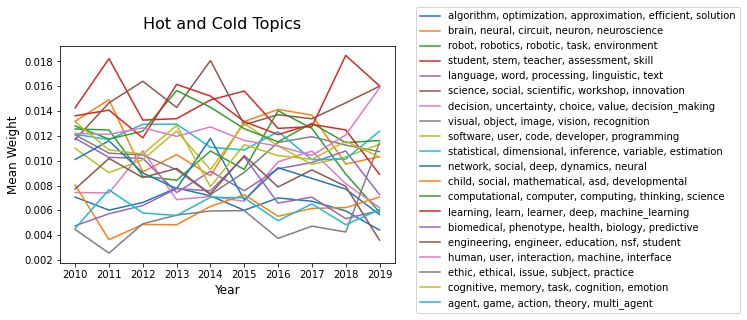

In [186]:
#Make Graphs
#leg = []
topic_results = {}
fig = plt.figure()
fig.suptitle('Hot and Cold Topics', fontsize=16)
ax = fig.add_subplot(111)

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    topic_results[i] = linear_fit.coef_[0][0]
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,i])
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [187]:
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


In [188]:
# {column index, slope} - ex) 1: Topic 0 because Topic 0 is column 1 in the dataframe

#topic_results

In [189]:
def sort_dict(x):
    return sorted(x.items(), key=lambda l: l[1], reverse=True)

In [190]:
sort_slopes = sort_dict(topic_results)
top_slopes = [x[0] for x in sort_slopes[:5]]
bottom_slopes = [x[0] for x in sort_slopes[-5:]]

In [191]:
sort_slopes[:5]

[(18, 0.00041365460854025357),
 (12, 0.00011364157145298254),
 (17, 0.00011077292268836083),
 (6, 0.00010060120440805882),
 (4, 8.112584198446405e-05)]

In [192]:
top_slopes

[18, 12, 17, 6, 4]

In [193]:
bottom_slopes

[5, 3, 16, 14, 11]

### plot hottest and coldest on same plot

In [194]:
# for plotting hot and cold on same graph

topnbot_slopes = top_slopes + bottom_slopes

In [195]:
topnbot_slopes

[18, 12, 17, 6, 4, 5, 3, 16, 14, 11]

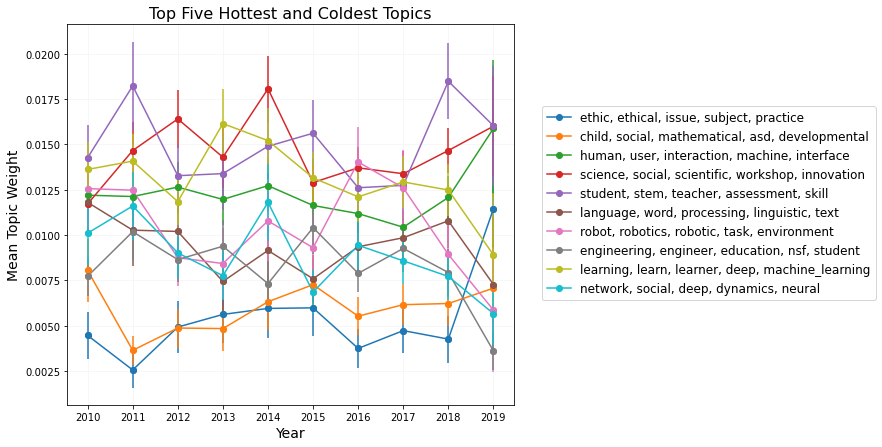

In [196]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in topnbot_slopes:
    zorder = 20
    color = color_list[i] 
    #if i < 5:
    #    zorder = 10 #10
    #    color = "#D3D3D3";
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.001, top = 0.05)
plt.title('Top Five Hottest and Coldest Topics', fontsize=16)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in topnbot_slopes], handler_map={type(line_return[0]): HandlerDashedLines()})
           #handlelength=2, bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')  #handleheight=2,

plt.legend([leg[x-1] for x in topnbot_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/updated_full_hot_cold_topics.png", dpi = 800, bbox_inches = "tight")
plt.show()


### Plot hottest and coldest topics on separate plots

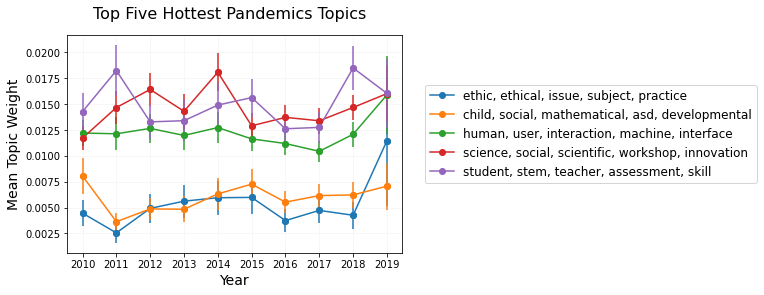

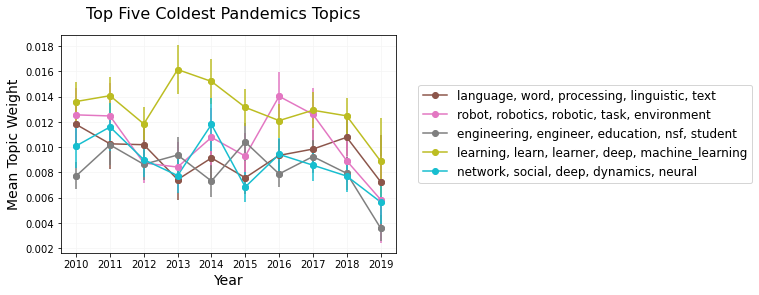

In [197]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]
#color_list = ["#D3D3D3","#2c4f6b","#C0C0C0","#A9A9A9","#808080","#D3D3D3","#2c4f6b","#D3D3D3","#D3D3D3", "#D3D3D3"] #"#fdfdfd"]


line_return = []
fig = plt.figure()
fig.suptitle('Top Five Hottest Pandemics Topics', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in top_slopes:
    zorder = 10
    color = color_list[i] # "#D3D3D3"   
    if i == 0:
        zorder = 10 #20
        color = color_list[i];
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.002, top = 0.065)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
#plt.legend(line_return, [leg[x-1] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in top_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
plt.savefig("/home/zz3hs/git/dspg21RnD/www/bert_20topic_trends_hot.png", dpi = 800, bbox_inches = "tight")
plt.show()


#Make Graphs
#leg = []

#bottom_slopes.reverse()  # so the plot legend has the coldest listed first

line_return = []
fig = plt.figure()
fig.suptitle('Top Five Coldest Pandemics Topics', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
i = 0
for n in bottom_slopes:
    zorder = 10
    color = color_list[i+5]  #"#D3D3D3"  
    if i == 4:
        zorder = 10 #20
        color = color_list[i+5]
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i+5])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color=color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color=color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i+5],color_list[i+5]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.002, top = 0.065)
#ax.yaxis.set_label_coords(-0.14,0.5)


# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in bottom_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
plt.savefig("/home/zz3hs/git/dspg21RnD/www/bert_20topic_trends_cold.png", dpi = 800, bbox_inches = "tight")
plt.show()


### create plot for specific topics

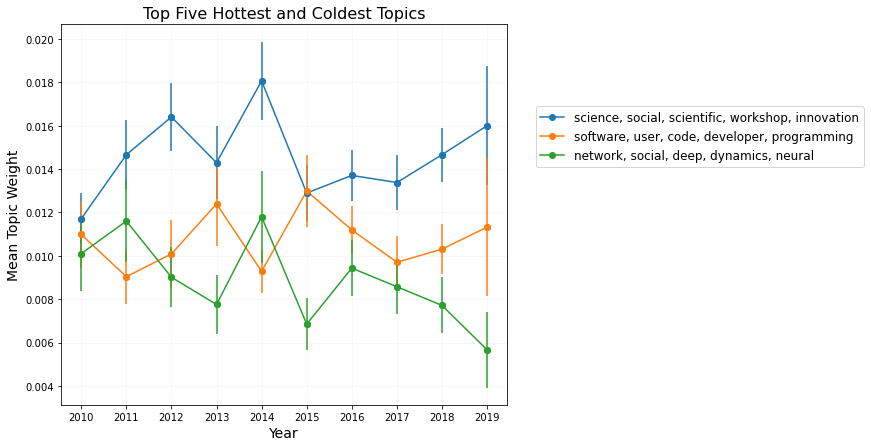

In [198]:
# Create plots for data stories in ET paper - topic numbers: 5, 8, 10 + 1 due to year being column 1

topic_idx = [6, 9, 11]

# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in topic_idx:
    zorder = 20
    color = color_list[i] 
    #if i < 5:
    #    zorder = 10 #10
    #    color = "#D3D3D3";
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.001, top = 0.05)
plt.title('Top Five Hottest and Coldest Topics', fontsize=16)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
#plt.legend(line_return, [leg[x-1] for x in topic_idx], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in topic_idx], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/case-study.png", dpi = 800, bbox_inches = "tight")
plt.show()


## Plot for each topic in a grid

In [199]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 1 to 30

# leg: indices 0-29

[18, 12, 17, 6, 4, 15, 9, 8, 7, 20, 13, 2, 10, 19, 1, 5, 3, 16, 14, 11]

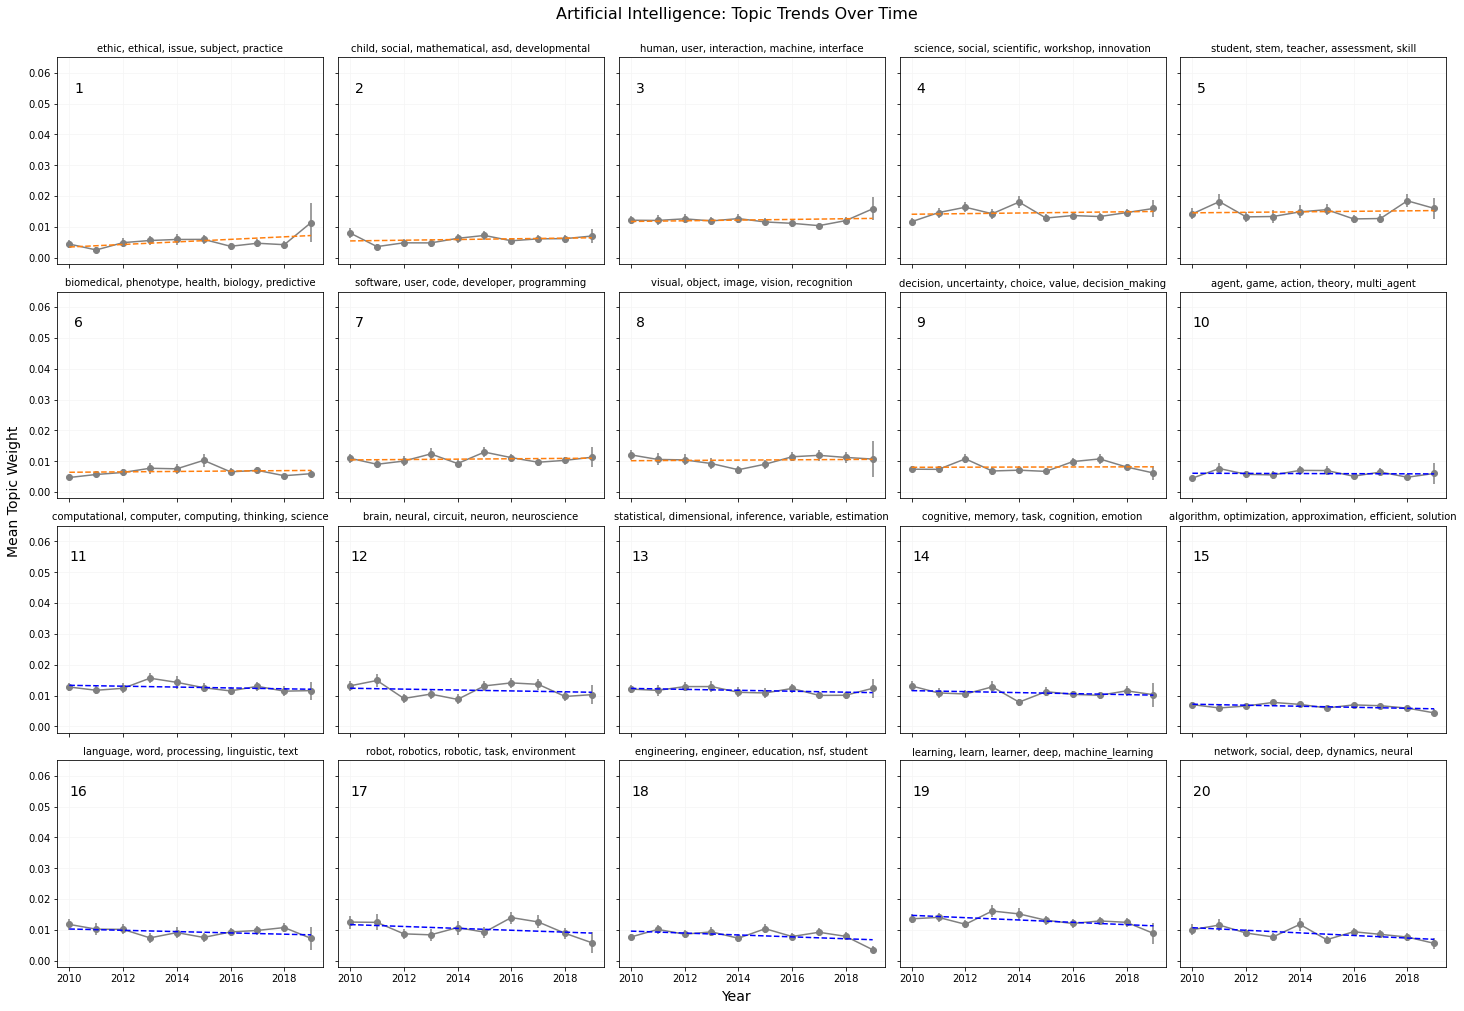

In [202]:
# set up grid
fig, ax = plt.subplots(4, 5, sharex = True, sharey = True, figsize=(20,14))
plt.ylim(bottom = -0.002, top = 0.065)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")

    ax[i,j].set_title(leg[col_idx-1], fontsize = 10)
    
    # put legend on two lines for topics 2, 28
    #if count == 1:
    #    ax[i,j].set_title('influenza, task, phage_display_library, \n surface_plasmon_resonance, vaccinate', \
    #                      fontsize = 8)
    #elif count == 27:
    #    ax[i,j].set_title('virus, gastroenteritis, thesedisease, \n respiratory_tract, genomic', fontsize = 8)
    #else:
    #    ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Artificial Intelligence: Topic Trends Over Time', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

plt.savefig("/home/zz3hs/git/dspg21RnD/www/bert_20topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

In [41]:
# get legend items for too long titles (topic 2)

leg[25]
leg[28]

'virus, gastroenteritis, thesedisease, respiratory_tract, genomic'

### Descriptive statistics on corpus

In [42]:
df["START_YEAR"].value_counts()

2008    107
2009     91
2010     89
2015     74
2011     71
2013     68
2016     63
2012     60
2014     59
2017     51
2018     45
2007     30
2019     30
2005     25
2004     18
2006     17
2001      9
1997      6
1985      5
1991      5
2002      5
1998      4
2003      4
1987      3
1981      3
1988      2
1980      2
1999      2
1975      2
1990      2
1977      1
1996      1
1979      1
1992      1
2000      1
Name: START_YEAR, dtype: int64

In [43]:
df["DEPARTMENT"].value_counts()

HHS     864
USDA     56
NSF      25
NASA      5
DOD       4
VA        3
Name: DEPARTMENT, dtype: int64

In [44]:
# filter data frame by year and repeat descriptive statistics.  Limit years to those for emerging topic analysis.

filt_df = df.copy()
filt_df["START_YEAR"] = filt_df["START_YEAR"].astype('int')

filt_df = filt_df[filt_df["START_YEAR"] > 2009]
filt_df = filt_df[filt_df["START_YEAR"] < 2020]

In [48]:
filt_df["START_YEAR"].value_counts().sort_index()

2010    89
2011    71
2012    60
2013    68
2014    59
2015    74
2016    63
2017    51
2018    45
2019    30
Name: START_YEAR, dtype: int64

In [46]:
filt_df["DEPARTMENT"].value_counts()

HHS     544
USDA     34
NSF      21
DOD       4
NASA      4
VA        3
Name: DEPARTMENT, dtype: int64

In [47]:
filt_df.pivot_table(index=['DEPARTMENT','START_YEAR'], aggfunc='size')

DEPARTMENT  START_YEAR
DOD         2015           1
            2018           1
            2019           2
HHS         2010          80
            2011          69
            2012          55
            2013          55
            2014          51
            2015          63
            2016          52
            2017          49
            2018          42
            2019          28
NASA        2010           1
            2015           2
            2016           1
NSF         2010           2
            2012           3
            2013           3
            2014           2
            2015           2
            2016           6
            2017           1
            2018           2
USDA        2010           5
            2011           1
            2012           2
            2013           9
            2014           6
            2015           6
            2016           4
            2017           1
VA          2010           1
            2011    